#Setup and Config

In [13]:
# %% [markdown]
# # Wordle Solver Evaluation – Modular Framework

# %%
import math, random, json, time, itertools, collections, statistics, os, csv
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Iterable, Optional, Any
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
random.seed(42)
np.random.seed(42)

# Paths
RESULTS_DIR = "results"
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
SUMMARY_DIR = os.path.join(RESULTS_DIR, "summary")
for d in (RESULTS_DIR, PLOTS_DIR, SUMMARY_DIR):
    os.makedirs(d, exist_ok=True)

# Config – Fast vs Full evaluation
CONFIG = {
    "mode": "fast",           # "fast" or "full"
    "fast_n_targets": 100,
    "fast_repeats": 10,      # repeats per solver (each repeat samples a new target from the subset)
    "full_repeats": 1,        # one pass per target
    "hard_mode": False,       # if True, legal guesses must satisfy known greens/yellows
    "allow_probes": True,     # if True, entropy/MCTS may guess any valid word (not just candidates)
    "mcts": {
        "rollouts_per_move": 400,   # tune in fast mode; fix for full
        "ucb_c": 1.4
    }
}
print("CONFIG:", json.dumps(CONFIG, indent=2))


# ---- ANALYSIS CONFIG (add at end of your existing CONFIG cell) ----
CONFIG["analysis"] = {
    "log_turns": True,          # log a row per turn for any solver
    "topk": 10,                 # store top-K choices per solver/turn (as JSON)
    "log_dir": "results/summary",
}
os.makedirs(CONFIG["analysis"]["log_dir"], exist_ok=True)

# One file for per-turn logs (all solvers go here)
TURNLOG_CSV = os.path.join(CONFIG["analysis"]["log_dir"], f"turnlog_{CONFIG['mode']}.csv")

# Write header once per run (safe if file exists)
if not os.path.exists(TURNLOG_CSV):
    import csv
    with open(TURNLOG_CSV, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow([
            "game_id","solver","turn","target",
            "candidates_before","guess","pattern_str",
            "success_on_turn","is_probe",
            "score_name","score_value","topk_json","extras_json"
        ])


CONFIG: {
  "mode": "fast",
  "fast_n_targets": 100,
  "fast_repeats": 10,
  "full_repeats": 1,
  "hard_mode": false,
  "allow_probes": true,
  "mcts": {
    "rollouts_per_move": 400,
    "ucb_c": 1.4
  }
}


YAML preset loader

In [ ]:
# %% [markdown]
# ## Presets (fast_dev / full_benchmark) via YAML

# %%
import os, sys, json, math, random, collections, statistics, itertools, csv, time, pathlib
from typing import List, Dict, Any

# Create config dir if missing
os.makedirs("config", exist_ok=True)

# Optional: install PyYAML in case it's not present
try:
    import yaml  # type: ignore
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyyaml"])
    import yaml

PRESETS_YAML = "config/presets.yaml"

# Write a sensible default presets file once (you can edit later)
if not os.path.exists(PRESETS_YAML):
    presets_text = """
fast_dev:
  mode: "fast"
  # sampler
  fast_n_targets: 200
  fast_repeats: 20
  full_repeats: 1
  # gameplay
  hard_mode: false
  allow_probes: true
  # mcts
  mcts:
    rollouts_per_move: 100
    ucb_c: 1.4
  # analysis/logging
  analysis:
    log_turns: true
    topk: 10

full_benchmark:
  mode: "full"
  # sampler
  fast_n_targets: 200     # unused in full, kept for consistency
  fast_repeats: 1         # unused in full, kept for consistency
  full_repeats: 1
  # gameplay
  hard_mode: false
  allow_probes: true
  # mcts
  mcts:
    rollouts_per_move: 400
    ucb_c: 1.4
  # analysis/logging
  analysis:
    log_turns: true
    topk: 10
""".strip() + "\n"
    with open(PRESETS_YAML, "w") as f:
        f.write(presets_text)
    print(f"Wrote default presets to {PRESETS_YAML}")


Define defaults

In [ ]:
# %% [markdown]
# ## Load a preset and merge over defaults

# %%
from copy import deepcopy

# Minimal base defaults. These get overridden by YAML profile values.
CONFIG_DEFAULTS = {
    "mode": "fast",
    "fast_n_targets": 200,
    "fast_repeats": 20,
    "full_repeats": 1,
    "hard_mode": False,
    "allow_probes": True,
    "mcts": {"rollouts_per_move": 100, "ucb_c": 1.4},
    "analysis": {"log_turns": True, "topk": 10, "log_dir": "results/summary"},
}

SUMMARY_DIR = "results/summary"
PLOTS_DIR = "results/plots"
os.makedirs(SUMMARY_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

def deep_merge(base: Dict[str, Any], override: Dict[str, Any]) -> Dict[str, Any]:
    out = deepcopy(base)
    for k, v in (override or {}).items():
        if isinstance(v, dict) and isinstance(out.get(k), dict):
            out[k] = deep_merge(out[k], v)
        else:
            out[k] = v
    return out

def load_preset(name: str, path: str = PRESETS_YAML) -> Dict[str, Any]:
    with open(path, "r") as f:
        all_presets = yaml.safe_load(f) or {}
    if name not in all_presets:
        raise KeyError(f"Preset '{name}' not found in {path}. Available: {list(all_presets.keys())}")
    return all_presets[name]

def dict_diff(a: Dict[str, Any], b: Dict[str, Any]) -> Dict[str, Any]:
    # show only keys where b differs from a (for a clean “what the preset changed” print-out)
    out = {}
    for k in sorted(set(a.keys()) | set(b.keys())):
        av, bv = a.get(k), b.get(k)
        if isinstance(av, dict) and isinstance(bv, dict):
            sub = dict_diff(av, bv)
            if sub:
                out[k] = sub
        elif av != bv:
            out[k] = {"default": av, "preset": bv}
    return out

# ---- Choose a preset here (ONE LINE TO SWITCH) ----
PROFILE = "fast_dev"   # change to "full_benchmark" when you run the final sweep

# Allow override via environment or notebook variable if you like:
PROFILE = os.environ.get("WORDLE_PROFILE", PROFILE)

# Load & merge
preset_cfg = load_preset(PROFILE)
CONFIG = deep_merge(CONFIG_DEFAULTS, preset_cfg)

print(f"Loaded preset: {PROFILE}")
print("CONFIG (compact):")
print(json.dumps(CONFIG, indent=2))

print("\nChanges from defaults:")
print(json.dumps(dict_diff(CONFIG_DEFAULTS, CONFIG), indent=2))


In [ ]:
# Ensure logging directories exist (safe to run multiple times)
os.makedirs(CONFIG["analysis"].get("log_dir", SUMMARY_DIR), exist_ok=True)


Word Lists

In [4]:
# %% [markdown]
# ## Load Word Lists (local files)

# %%
def load_words_from_file(path: str):
    with open(path, "r") as f:
        words = [w.strip().lower() for w in f if len(w.strip()) == 5 and w.strip().isalpha()]
    return sorted(set(words))

# Local file paths (adjust if necessary)
ANSWERS_FILE = "wordle-answers-alphabetical.txt"
GUESSES_FILE = "wordle-allowed-guesses.txt"

target_words = load_words_from_file(ANSWERS_FILE)   # ~2309 words
valid_words  = load_words_from_file(GUESSES_FILE)   # ~10k words

# Combine for all legal guesses
all_valid_words = sorted(set(target_words) | set(valid_words))

print(f"Loaded {len(target_words)} target words, {len(valid_words)} valid guesses, {len(all_valid_words)} unique legal words.")
print("Examples (targets):", target_words[:10])
print("Examples (valids):", valid_words[:10])


Loaded 2315 target words, 10657 valid guesses, 12972 unique legal words.
Examples (targets): ['aback', 'abase', 'abate', 'abbey', 'abbot', 'abhor', 'abide', 'abled', 'abode', 'abort']
Examples (valids): ['aahed', 'aalii', 'aargh', 'aarti', 'abaca', 'abaci', 'abacs', 'abaft', 'abaka', 'abamp']


Feedback and Filtering(repeat safe)

In [5]:
# %%
# Tile codes: 2=green, 1=yellow, 0=grey
Pattern = Tuple[int, int, int, int, int]

def feedback_pattern(guess: str, secret: str) -> Pattern:
    """Compute Wordle feedback with correct handling of repeated letters."""
    g = list(guess)
    s = list(secret)
    res = [0]*5

    # Greens
    for i in range(5):
        if g[i] == s[i]:
            res[i] = 2
            s[i] = None  # consumed
            g[i] = None

    # Yellows
    for i in range(5):
        if g[i] is not None:
            try:
                j = s.index(g[i])
                res[i] = 1
                s[j] = None  # consume that occurrence
            except ValueError:
                pass
    return tuple(res)

def consistent(word: str, guess: str, patt: Pattern) -> bool:
    return feedback_pattern(guess, word) == patt

# Cache to speed entropy/MCTS
PATTERN_CACHE: Dict[Tuple[str,str], Pattern] = {}
def cached_pattern(g: str, c: str) -> Pattern:
    key = (g, c)
    if key not in PATTERN_CACHE:
        PATTERN_CACHE[key] = feedback_pattern(g, c)
    return PATTERN_CACHE[key]


Base Solver API

In [6]:
# %%
class Solver:
    name = "Base"

    def reset(self):
        """Reset any internal state before a new game."""
        pass

    def guess(self, candidates: List[str], valid: List[str], history: List[Tuple[str, Pattern]], hard_mode: bool) -> str:
        """Return a legal guess."""
        raise NotImplementedError


Uniform Diagnostics API for all solvers

In [14]:
# ---- DIAGNOSTICS MIXIN (after Base Solver class) ----
class WithDiagnostics:
    def reset_diag(self):
        self._diag = {
            "score_name": None,       # e.g., "entropy_bits", "heuristic_score", "ucb_Q", "none"
            "score_value": None,
            "is_probe": None,         # True if guess not in candidates
            "topk": [],               # list of (word, score) for top-K
            "extras": {},             # free-form: buckets, ucb_parts, visits, etc.
        }

    def diag(self):
        # return a copy to avoid mutation surprises
        return dict(self._diag)

# Update the base Solver to inherit this (or mix into each concrete solver)
class Solver(WithDiagnostics):
    name = "Base"
    def reset(self):
        self.reset_diag()
    def guess(self, candidates, valid, history, hard_mode):
        raise NotImplementedError


Random Solver

In [17]:
class RandomSolver(Solver):
    name = "Random"
    def guess(self, candidates, valid, history, hard_mode):
        self.reset_diag()
        pool = candidates  # keep admissible
        g = random.choice(pool) if pool else random.choice(valid)
        self._diag.update({
            "score_name": "none",
            "score_value": None,
            "is_probe": (g not in candidates),
            "topk": [],
            "extras": {}
        })
        return g



Heuristic Solver (freq + vowels)

In [18]:
# %%
# Letter frequencies from target_words (unigram); positional priors optional
from collections import Counter

letter_counts = Counter("".join(target_words))
total_letters = sum(letter_counts.values())
letter_freq = {ch: letter_counts[ch]/total_letters for ch in 'abcdefghijklmnopqrstuvwxyz'}

def heuristic_score(word: str, use_positional: bool=False) -> float:
    score = sum(letter_freq.get(ch, 0) for ch in set(word))  # distinct letters to encourage coverage
    # vowel coverage bonus
    vowels = set(word) & set("aeiou")
    score += 0.05*len(vowels)
    # penalty for repeats
    if len(set(word)) < 5:
        score -= 0.05
    return score

class HeuristicSolver(Solver):
    name = "Heuristic"
    def guess(self, candidates, valid, history, hard_mode):
        self.reset_diag()
        pool = candidates
        # rank pool by heuristic_score
        scored = [(w, heuristic_score(w)) for w in pool]
        scored.sort(key=lambda x: x[1], reverse=True)
        g, sc = scored[0]
        self._diag.update({
            "score_name": "heuristic_score",
            "score_value": float(sc),
            "is_probe": (g not in candidates),
            "topk": scored[:CONFIG["analysis"]["topk"]],
            "extras": {}
        })
        return g



Entropy Solver (expected information gain with caching)

In [19]:
# %%
def partitions_for_guess(guess: str, candidates: List[str]) -> Dict[Pattern, int]:
    buckets = collections.Counter(cached_pattern(guess, c) for c in candidates)
    return buckets

def entropy_of_guess(guess: str, candidates: List[str]) -> float:
    N = len(candidates)
    if N <= 1:
        return 0.0
    buckets = partitions_for_guess(guess, candidates)
    H = 0.0
    for n in buckets.values():
        p = n / N
        H -= p * math.log(p, 2)
    return H

class EntropySolver(Solver):
    name = "Entropy"
    def guess(self, candidates, valid, history, hard_mode):
        self.reset_diag()
        pool = candidates if (hard_mode or not CONFIG["allow_probes"]) else all_valid_words

        # optional prune by heuristic for speed
        K_prune = 2000 if len(pool) > 3000 else len(pool)
        if K_prune < len(pool):
            pool = sorted(pool, key=heuristic_score, reverse=True)[:K_prune]

        if CONFIG["analysis"]["log_turns"] and turn == 1:
          # log the top-K by entropy
          ranked = sorted(scores.items(), key=lambda kv: -kv[1])[:CONFIG["analysis"]["topk"]]
          with open(outdir / f"{self.name}_entropy_topk.csv", "a") as f:
              writer = csv.writer(f)
              writer.writerow([game_id, turn] + [w for w, _ in ranked])


        scored = []
        for g in pool:
            H = entropy_of_guess(g, candidates)
            scored.append((g, H))
        scored.sort(key=lambda x: x[1], reverse=True)
        best_g, best_H = scored[0]

        # buckets for chosen
        buckets = partitions_for_guess(best_g, candidates)
        bucket_sizes = {str(p): n for p, n in buckets.items()}

        self._diag.update({
            "score_name": "entropy_bits",
            "score_value": float(best_H),
            "is_probe": (best_g not in candidates),
            "topk": [(w, float(h)) for w,h in scored[:CONFIG["analysis"]["topk"]]],
            "extras": {"bucket_sizes": bucket_sizes, "pool_size": len(pool)}
        })
        return best_g


MCTS

In [20]:
# %%
@dataclass
class Node:
    candidates: Tuple[str, ...]       # immutable for hashing
    guess: Optional[str] = None       # guess that led here (None at root)
    pattern: Optional[Pattern] = None # feedback observed at edge into this node
    parent: Optional["Node"] = None
    children: Dict[Tuple[str, Pattern], "Node"] = field(default_factory=dict)
    N: int = 0
    W: float = 0.0                    # cumulative reward (higher better)

    def ucb(self, c=1.4) -> float:
        if self.N == 0:
            return float("inf")
        Q = self.W / self.N
        return Q + c * math.sqrt(math.log(self.parent.N + 1) / self.N)

def next_candidates(cands: List[str], guess: str, patt: Pattern) -> List[str]:
    return [w for w in cands if consistent(w, guess, patt)]

def rollout_policy(cands: List[str]) -> str:
    # quick policy: heuristic among candidates
    return max(cands, key=heuristic_score) if cands else ""

def simulate_to_terminal(cands: List[str], max_guesses_left: int = 6) -> Tuple[bool, int]:
    """Return (success, guesses_used) from this state using a fast policy."""
    guesses_used = 0
    remaining = list(cands)
    while guesses_used < max_guesses_left and remaining:
        guess = rollout_policy(remaining)
        guesses_used += 1
        # sample a plausible secret uniformly (simulation)
        secret = random.choice(remaining)
        patt = cached_pattern(guess, secret)
        remaining = next_candidates(remaining, guess, patt)
        if guess == secret:
            return True, guesses_used
    return False, guesses_used

class MCTSSolver(Solver):
    name = "MCTS"
    def guess(self, candidates, valid, history, hard_mode):
        self.reset_diag()
        root = Node(tuple(sorted(candidates)))
        c_ucb = CONFIG["mcts"]["ucb_c"]
        R = CONFIG["mcts"]["rollouts_per_move"]
        pool = candidates if (hard_mode or not CONFIG["allow_probes"]) else all_valid_words

        for _ in range(R):
            node = root
            path = [node]
            # selection
            while node.children:
                node = max(node.children.values(), key=lambda n: n.ucb(c_ucb))
                path.append(node)
            # expansion
            if len(node.candidates) > 1:
                K = 50 if len(pool) > 500 else min(50, len(pool))
                guess_candidates = sorted(pool, key=heuristic_score, reverse=True)[:K]
                g = random.choice(guess_candidates)
                secret = random.choice(node.candidates)
                patt = cached_pattern(g, secret)
                new_cands = tuple(sorted(next_candidates(list(node.candidates), g, patt)))
                child = node.children.get((g, patt))
                if child is None:
                    child = Node(candidates=new_cands, guess=g, pattern=patt, parent=node)
                    node.children[(g, patt)] = child
                node = child
                path.append(node)
                # simulation
                success, _ = simulate_to_terminal(list(node.candidates), max_guesses_left=6)
                reward = 1.0 if success else 0.0
            else:
                reward = 1.0  # single candidate considered solved in rollout

            # backprop
            for n in path:
                n.N += 1
                n.W += reward

        if not root.children:
            g = max(candidates or pool, key=heuristic_score)
            self._diag.update({
                "score_name": "ucb_Q",
                "score_value": None,
                "is_probe": (g not in candidates),
                "topk": [],
                "extras": {"rollouts": R, "note": "no_children_fallback"}
            })
            return g

        # pick best child by visits
        # collect per-(guess,pattern) stats for topK
        child_stats = []
        for (g,p), n in root.children.items():
            Q = (n.W/n.N) if n.N>0 else 0.0
            U = (c_ucb * math.sqrt(math.log(root.N+1)/n.N)) if n.N>0 else float('inf')
            child_stats.append((g, n.N, Q, Q+U))
        child_stats.sort(key=lambda x: x[1], reverse=True)  # by visits
        best_g = child_stats[0][0]

        self._diag.update({
            "score_name": "ucb_Q",
            "score_value": float(child_stats[0][2]),  # Q of chosen
            "is_probe": (best_g not in candidates),
            "topk": [(g, float(Q)) for (g, visits, Q, u) in child_stats[:CONFIG["analysis"]["topk"]]],
            "extras": {
                "rollouts": R,
                "topk_visits": [(g, int(v)) for (g, v, Q, u) in child_stats[:CONFIG["analysis"]["topk"]]],
                "topk_ucb": [(g, float(u)) for (g, v, Q, u) in child_stats[:CONFIG["analysis"]["topk"]]]
            }
        })
        return best_g



RL Exploratory Stub

In [11]:
# %%
class RLSolver(Solver):
    name = "RL_exp"
    def __init__(self):
        self.Q = {}  # very coarse state -> action value
        self.alpha = 0.10
        self.gamma = 0.95
        self.eps   = 0.10
    def state_key(self, candidates, history):
        # coarse encoding: (len(candidates), seen_green_positions_mask, seen_yellow_letters_set)
        greens = [i for (g,p) in history for i,v in enumerate(p) if v==2]
        ys = sorted({g[i] for (g,p) in history for i,v in enumerate(p) if v==1})
        return (len(candidates), tuple(sorted(greens)), tuple(ys))
    def guess(self, candidates, valid, history, hard_mode):
        state = self.state_key(candidates, history)
        acts = candidates  # keep admissible; huge action space, this is exploratory only
        if not acts:
            return random.choice(valid)
        if random.random() < self.eps:
            return random.choice(acts)
        # greedy
        qvals = self.Q.get(state, {})
        return max(acts, key=lambda a: qvals.get(a, 0.0))


Game Engine, Runner, Metrics, CSV

In [24]:
# %%
@dataclass
class GameResult:
    solver: str
    target: str
    success: bool
    guesses: int
    sequence: List[str]

import json, csv

def append_turn_log(game_id, solver, turn, target, cand_before, guess, patt, success_on_turn):
    if not CONFIG["analysis"]["log_turns"]:
        return
    d = solver.diag() if hasattr(solver, "diag") else {}
    pattern_str = "".join(str(x) for x in patt)  # e.g., 20110
    with open(TURNLOG_CSV, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow([
            game_id, solver.name, turn, target,
            cand_before, guess, pattern_str,
            int(bool(success_on_turn)),
            int(d.get("is_probe")) if d.get("is_probe") is not None else "",
            d.get("score_name"), d.get("score_value"),
            json.dumps(d.get("topk", [])),
            json.dumps(d.get("extras", {}))
        ])


def play_game(target: str, solver: Solver, hard_mode=False, allow_probes=True, valid=all_valid_words, game_id=None) -> GameResult:
    candidates = [w for w in target_words]
    history = []
    seq = []
    solver.reset()

    for turn in range(1, 7):
        cand_before = len(candidates)
        g = solver.guess(candidates, all_valid_words if allow_probes else candidates, history, hard_mode)
        seq.append(g)
        patt = cached_pattern(g, target)
        history.append((g, patt))

        # log this turn
        append_turn_log(
            game_id=game_id,
            solver=solver,
            turn=turn,
            target=target,
            cand_before=cand_before,
            guess=g,
            patt=patt,
            success_on_turn=(g == target)
        )

        if g == target:
            return GameResult(solver=solver.name, target=target, success=True, guesses=turn, sequence=seq)

        candidates = [w for w in candidates if consistent(w, g, patt)]

    return GameResult(solver=solver.name, target=target, success=False, guesses=6, sequence=seq)


from tqdm import tqdm

def run_benchmark(solvers: List[Solver], mode=None):
    mode = mode or CONFIG["mode"]
    if mode == "fast":
        subset = random.sample(target_words, k=min(CONFIG["fast_n_targets"], len(target_words)))
        repeats = CONFIG["fast_repeats"]
    else:
        subset = list(target_words)
        repeats = CONFIG["full_repeats"]

    total_games = len(solvers) * repeats * len(subset)
    pbar = tqdm(total=total_games, desc=f"Running {mode} benchmark", ncols=100)

    rows = []
    gid = 0
    for s in solvers:
        for r in range(repeats):
            for t in subset:
                gid += 1
                res = play_game(
                    t, s,
                    hard_mode=CONFIG["hard_mode"],
                    allow_probes=CONFIG["allow_probes"],
                    game_id=gid
                )
                rows.append(res)
                pbar.update(1)
    pbar.close()

    # ... keep your CSV summary + metrics writing as-is ...
    return rows, metrics

    # track first guesses separately
    first_guess_tracker = collections.Counter()

    # for each solver
    for s in solvers:
        ...
        for r in range(repeats):
            for t in subset:
                res = play_game(t, s, ...)

                rows.append(res)

                # log first guess
                if res["guesses"]:
                    first_guess_tracker[res["guesses"][0]] += 1

        # --- after loop, dump per-solver summaries ---
        outdir = Path(CONFIG["analysis"].get("log_dir", "results/summary"))
        outdir.mkdir(parents=True, exist_ok=True)

        # first-guess frequencies
        fg_file = outdir / f"{s.name}_first_guesses.csv"
        with open(fg_file, "w") as f:
            writer = csv.writer(f)
            writer.writerow(["guess", "count"])
            writer.writerows(first_guess_tracker.most_common())
        print(f"Saved first-guess distribution for {s.name} → {fg_file}")



    # Write per-game CSV
    out_csv = os.path.join(SUMMARY_DIR, f"games_{mode}.csv")
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["solver","target","success","guesses","sequence"])
        for r in rows:
            w.writerow([r.solver, r.target, int(r.success), r.guesses, " ".join(r.sequence)])
    print("Wrote:", out_csv)

    # Aggregate metrics
    metrics = []
    for name, group in itertools.groupby(sorted(rows, key=lambda x: x.solver), key=lambda x: x.solver):
        g = list(group)
        n = len(g)
        wins = sum(r.success for r in g)
        fail = n - wins
        win_rate = 100 * wins / n if n else 0.0
        avg_guesses = statistics.mean([r.guesses for r in g if r.success]) if wins else float("nan")

        dist = collections.Counter(r.guesses for r in g if r.success)
        row = {
            "solver": name,
            "n_games": n,
            "win_rate": win_rate,
            "avg_guesses_success": avg_guesses,
            "fail_rate": 100 - win_rate,
            "p_solved_2": dist.get(2,0)/n,
            "p_solved_3": dist.get(3,0)/n,
            "p_solved_4": dist.get(4,0)/n,
            "p_solved_5": dist.get(5,0)/n,
            "p_solved_6": dist.get(6,0)/n,
        }
        metrics.append(row)

    # Write summary CSV
    out_csv2 = os.path.join(SUMMARY_DIR, f"metrics_{mode}.csv")
    with open(out_csv2, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(metrics[0].keys()))
        w.writeheader()
        w.writerows(metrics)
    print("Wrote:", out_csv2)
    return rows, metrics





In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(rows)

# Distribution of guesses
plt.hist(df["num_guesses"], bins=[1,2,3,4,5,6,7], rwidth=0.8)
plt.title(f"Guess distribution - {s.name}")
plt.xlabel("Guesses used")
plt.ylabel("Frequency")
plt.savefig(PLOTS_DIR + f"/{s.name}_guess_distribution.png")

# Cumulative success curve
cum = df["num_guesses"].value_counts().sort_index().cumsum() / len(df)
cum.plot(drawstyle="steps-post")
plt.title(f"Cumulative success curve - {s.name}")
plt.xlabel("Guess number")
plt.ylabel("Cumulative proportion solved")
plt.savefig(PLOTS_DIR + f"/{s.name}_cumulative_success.png")


#Plots/Analysis for Report

In [ ]:
# %%
import pandas as pd

def plot_guess_distribution(rows: List[GameResult], title="Distribution of guesses"):
    data = [(r.solver, r.guesses) for r in rows if r.success]
    if not data:
        print("No successful games to plot.")
        return
    df = pd.DataFrame(data, columns=["solver","guesses"])
    # bar of proportions per solver
    solvers = sorted(df["solver"].unique())
    maxg = 6
    fig, ax = plt.subplots(figsize=(7,4))
    for i, s in enumerate(solvers):
        sub = df[df.solver==s]["guesses"].value_counts().sort_index()
        xs = list(range(2, maxg+1))
        ys = [sub.get(k,0)/len(df[df.solver==s]) for k in xs]
        ax.plot(xs, np.cumsum(ys), marker="o", label=s)  # cumulative success curve
    ax.set_xlabel("Guess number")
    ax.set_ylabel("Cumulative proportion solved")
    ax.set_title("Cumulative proportion solved by guess")
    ax.legend()
    path = os.path.join(PLOTS_DIR, "cumulative_success.png")
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    print("Saved:", path)

def plot_winrate_bars(metrics):
    df = pd.DataFrame(metrics)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(df["solver"], df["win_rate"])
    ax.set_ylabel("Win rate (%)")
    ax.set_title("Win rate by solver")
    path = os.path.join(PLOTS_DIR, "solver_winrate.png")
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    print("Saved:", path)

def plot_avg_guesses_bars(metrics):
    df = pd.DataFrame(metrics)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(df["solver"], df["avg_guesses_success"])
    ax.set_ylabel("Average guesses (successes)")
    ax.set_title("Avg guesses by solver")
    path = os.path.join(PLOTS_DIR, "solver_avg_guesses.png")
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    print("Saved:", path)


Golbal "best first guess" by entropy

In [23]:
def global_first_move_entropy(valid_pool=None, candidates_pool=None, out_path=None, topn=50):
    valid_pool = valid_pool or all_valid_words
    candidates_pool = candidates_pool or target_words
    scored = []
    for g in valid_pool:
        H = entropy_of_guess(g, candidates_pool)
        scored.append((g, H))
    scored.sort(key=lambda x: x[1], reverse=True)
    path = out_path or os.path.join(SUMMARY_DIR, "global_first_move_entropy.csv")
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["rank","word","entropy_bits"])
        for i,(g,H) in enumerate(scored, start=1):
            w.writerow([i, g, H])
    print("Wrote:", path)
    return scored[:topn]

top50 = global_first_move_entropy()


KeyboardInterrupt: 

Hardest words & high‑guess successes (for “Qualitative Error Analysis”)

In [ ]:
def hardest_words(rows):
    by_solver = collections.defaultdict(list)
    for r in rows:
        by_solver[r.solver].append(r)

    out = {}
    for s, lst in by_solver.items():
        fail_ct = collections.Counter([r.target for r in lst if not r.success]).most_common(20)
        # words that needed the most guesses (among successes)
        succ = [r for r in lst if r.success]
        by_word = collections.defaultdict(list)
        for r in succ:
            by_word[r.target].append(r.guesses)
        worst_solved = sorted(((w, statistics.mean(gs)) for w,gs in by_word.items()),
                              key=lambda x: x[1], reverse=True)[:20]
        out[s] = {"top_failures": fail_ct, "worst_solved": worst_solved}
    return out

hw = hardest_words(rows)
hw  # inspect or write to CSVs


Candidate‑set shrinkage trajectory (uniform — uses the turn log you’re writing)

In [ ]:
import pandas as pd
turnlog = pd.read_csv(TURNLOG_CSV)

# median/IQR of |C| before guess by solver/turn
stats = (turnlog.groupby(["solver","turn"])["candidates_before"]
         .agg(median="median",
              p25=lambda s: np.percentile(s,25),
              p75=lambda s: np.percentile(s,75))
         .reset_index())

plt.figure(figsize=(7,4))
for s in sorted(stats["solver"].unique()):
    sub = stats[stats["solver"]==s]
    plt.plot(sub["turn"], sub["median"], marker="o", label=s)
plt.yscale("log")
plt.xlabel("Turn"); plt.ylabel("|Candidates| before guess (median)")
plt.title("Candidate set shrinkage over turns")
plt.legend()
path = os.path.join(PLOTS_DIR, "candidate_shrinkage.png")
plt.tight_layout(); plt.savefig(path, dpi=200); print("Saved:", path)


Opener sensitivity (force an opener, then continue normally)

In [ ]:
def run_with_forced_opener(solver: Solver, opener: str, targets: list):
    rows = []
    for t in targets:
        candidates = [w for w in target_words]
        history, seq = [], []
        solver.reset()

        # forced turn 1
        g = opener
        seq.append(g)
        patt = cached_pattern(g, t)
        history.append((g, patt))
        if g == t:
            rows.append(GameResult(solver=solver.name+f"+forced:{opener}", target=t, success=True, guesses=1, sequence=seq))
            continue
        candidates = [w for w in candidates if consistent(w, g, patt)]

        # continue policy
        for turn in range(2, 7):
            cand_before = len(candidates)
            g = solver.guess(candidates, all_valid_words if CONFIG["allow_probes"] else candidates, history, CONFIG["hard_mode"])
            seq.append(g)
            patt = cached_pattern(g, t)
            history.append((g, patt))
            if g == t:
                rows.append(GameResult(solver=solver.name+f"+forced:{opener}", target=t, success=True, guesses=turn, sequence=seq))
                break
            candidates = [w for w in candidates if consistent(w, g, patt)]
        else:
            rows.append(GameResult(solver=solver.name+f"+forced:{opener}", target=t, success=False, guesses=6, sequence=seq))
    return rows

# Example (dev subset to keep it quick)
subset = random.sample(target_words, k=200)
rows_forced = []
for opener in ["crane","slate","soare"]:
    for s in [HeuristicSolver(), EntropySolver(), MCTSSolver()]:
        rows_forced += run_with_forced_opener(s, opener, subset)
# Aggregate rows_forced as usual for a small comparison table


Bootstrap CIs for win‑rate & avg guesses (for “Comparative differences & uncertainty”)

In [ ]:
def bootstrap_ci(samples, fn, B=2000, alpha=0.05, rng=None):
    rng = rng or np.random.default_rng(0)
    n = len(samples); stats = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        stats.append(fn(samples[idx]))
    stats.sort()
    lo = stats[int((alpha/2)*B)]
    hi = stats[int((1-alpha/2)*B)]
    return (lo, hi)

def summarize_with_cis(rows):
    by_solver = collections.defaultdict(list)
    for r in rows: by_solver[r.solver].append(r)
    out = []
    for s, lst in by_solver.items():
        succ = np.array([int(r.success) for r in lst])
        wr = succ.mean()*100
        wr_ci = [x*100 for x in bootstrap_ci(succ, np.mean)]
        gsucc = np.array([r.guesses for r in lst if r.success])
        if len(gsucc):
            avg = gsucc.mean()
            avg_ci = bootstrap_ci(gsucc, np.mean)
        else:
            avg, avg_ci = float("nan"), (float("nan"), float("nan"))
        out.append({
            "solver": s,
            "win_rate": wr, "win_rate_lo": wr_ci[0], "win_rate_hi": wr_ci[1],
            "avg_guesses": avg, "avg_lo": avg_ci[0], "avg_hi": avg_ci[1]
        })
    df = pd.DataFrame(out)
    path = os.path.join(SUMMARY_DIR, f"metrics_with_cis_{CONFIG['mode']}.csv")
    df.to_csv(path, index=False); print("Wrote:", path)
    return df

cis_df = summarize_with_cis(rows)
cis_df


#Demo Run (Fast), then switch to Full

Streaming output truncated to the last 5000 lines.
Running fast benchmark: 100%|█████████████████████████████████| 10000/10000 [53:46<00:00,  3.10it/s]


Wrote: results/summary/games_fast.csv
Wrote: results/summary/metrics_fast.csv
Saved: results/plots/cumulative_success.png
Saved: results/plots/solver_winrate.png
Saved: results/plots/solver_avg_guesses.png


,solver,n_games,win_rate,avg_guesses_success,fail_rate,p_solved_2,p_solved_3,p_solved_4,p_solved_5,p_solved_6
0,Entropy,10000,0.5,3,99.5,0.0,0.005,0.0,0.0,0.0


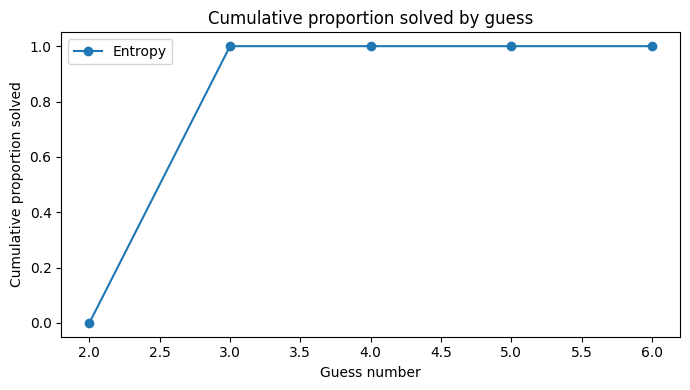

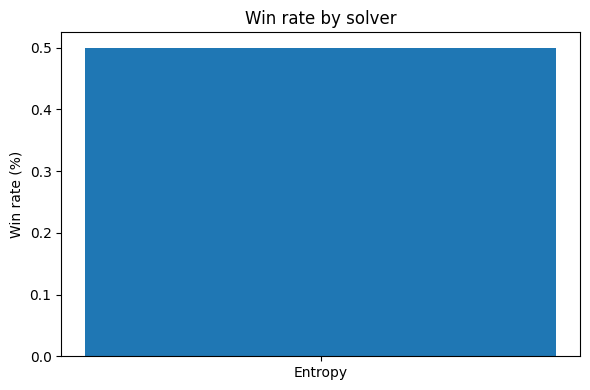

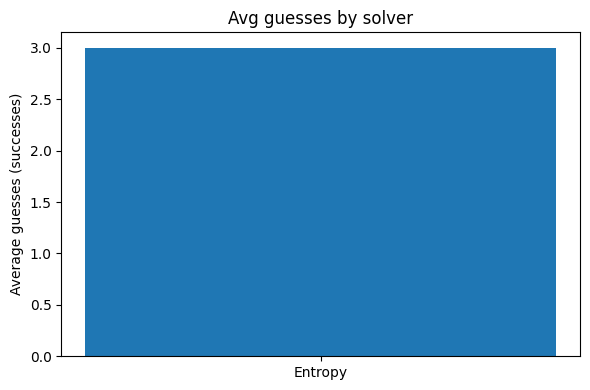

In [ ]:
# %%
# Instantiate solvers to benchmark
solvers = [
    RandomSolver(),
    #HeuristicSolver(),
    #EntropySolver(),
    #MCTSSolver(),
    # RLSolver(),  # optional exploratory
]

rows, metrics = run_benchmark(solvers, mode=CONFIG["mode"])

# Plots for the report
plot_guess_distribution(rows)
plot_winrate_bars(metrics)
plot_avg_guesses_bars(metrics)

# Quick pretty table
import pandas as pd
pd.DataFrame(metrics).round(3)


Feedback demo image

In [ ]:
# %%
def render_feedback_row(guess: str, secret: str) -> np.ndarray:
    patt = feedback_pattern(guess, secret)
    # simple raster: grey(0.3), yellow(0.8), green(0.5)
    colors = {0:0.3, 1:0.8, 2:0.5}
    img = np.zeros((60, 60*5))
    for i, v in enumerate(patt):
        img[:, i*60:(i+1)*60] = colors[v]
    return img, patt

def save_feedback_demo(guess: str, secret: str, fname="feedback_demo.png"):
    img, patt = render_feedback_row(guess, secret)
    plt.figure(figsize=(5,1.1))
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    path = os.path.join(PLOTS_DIR, fname)
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved:", path, "pattern:", patt)

save_feedback_demo("stare", "rigid", "feedback_demo.png")


Entropy partitions bar chart (for a single candidate guess)

In [ ]:
# %%
def save_entropy_partitions_demo(guess="stare", fname="entropy_partitions.png"):
    # choose a mid-sized candidate set (simulate early/mid game)
    # here we just use the full target list for illustration
    cands = target_words
    buckets = partitions_for_guess(guess, cands)
    labels = ["".join(map(str,b)) for b in buckets.keys()]
    sizes = list(buckets.values())
    # sort by size
    order = np.argsort(sizes)[::-1]
    sizes = [sizes[i] for i in order]
    labels = [labels[i] for i in order]
    plt.figure(figsize=(8,3))
    plt.bar(range(len(sizes)), sizes)
    plt.xlabel("Feedback pattern bucket")
    plt.ylabel("Bucket size")
    plt.title(f"Partitions for guess '{guess}' (H={entropy_of_guess(guess, cands):.2f} bits)")
    plt.tight_layout()
    path = os.path.join(PLOTS_DIR, fname)
    plt.savefig(path, dpi=200)
    print("Saved:", path)

save_entropy_partitions_demo("stare", "entropy_partitions.png")
